# Projet Lignes de niveau

On importe ces modules par principe de precaution

In [155]:
import autograd
from autograd import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

 Ceci est le notebook Jupyter contenant le projet de dessin de lignes de niveau sous python de Maud Roux-Salembien et Jérémy Costanzo

Soit f une fonction de $[0,1]^2$ vers $\mathbb{R}$ supposée continuement différentiable.

On cherche les ensembles de la forme : {$(x,y)\in\mathbb{R}^2|f(x,y)=c$} où c $\in$ $\mathbb{R}$

In [156]:
def f(x,y):
    return(x**2+y**2)
f(1,2)
#bouh

5

## <u>Contour simple</u>

### Amorce : 

Soit c $\in$ $\mathbb{R}$

On cherche une condition suffisante sur f(0,0) et f(0,1) pour qu'il existe t $\in$ [0,1] tel que f(0,t) = c

On sait que f est continuement différentiable, donc en particulier f(0,.), qui désigne la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(0,t).
\end{align*}$
est continue.


Ainsi, si c appartient au segment [min(f(0,0),f(0,1)),max(f(0,0),f(0,1))], le théorème des valeurs intermédiaires nous assure l'existence d'un t $\in$ [0,1] solution de f(0,t) = c.

Si la condition évoquée est satisfaite, on peut chercher numériquement une solution en utilisant la méthode de la dichotomie :

In [157]:
def find_seed(g,c=0,eps=2**(-26)):
    if (g(0)-c)*(g(1)-c) > 0:
        return None
    else:
        a = 0
        b = 1
        while b-a > eps:
            m = (a+b)/2
            if (g(m)-c)*(g(a)-c)<=0:
                b = m
            else:
                a = m
        t = (a+b)/2
        return t

La méthode des tangentes de Newton converge plus rapidement, mais nécessite plus d'hypothèses, et on ne peut pas savoir à quel point on est éloigné d'une solution, alors que la méthode de la dichotomie ne nécessite que la continuité de g, et permet de majorer la distance à une solution.

### Propagation

Une première approche pour implémenter la fonction simple_contour consisterait à subdiviser [0,1] en segments de taille $\delta$, et d'utiliser find_seed(g,c,eps) où g est la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(k\delta,t)
\end{align*}$ où k varie de 0 à int(1/$\delta$). Mais cela n'est pas satisfaisant, il faudrait réaliser environ 1/$\delta$ dichotomies, et l'équation f(k$\delta$,t) = c peut admettre plusieurs solutions éloignées les unes des autres.

Pour la suite, nous avons besoin de calculer le gradient de f en un point. Ainsi nous implementons une classe pt qui permet de representer des elements de $\mathbb{R}^2$, donc des points ou des vecteurs.

In [158]:
tolerance = 1**(-12) #un petit flottant, choisi un peu au pif pour l'instant...

class pt:
    def __init__(self,x=0.0,y=0.0):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return('{'+str(self.x)+','+str(self.y)+'}')
        
    def __mul__(a,b):
        if isinstance(b,int) or isinstance(b,float):
            return pt(a.x*b,a.y*b)
        else:
            return pt(a.x*b.x,a.y*b.y)
            
    def __rmul__(a,b):
        if isinstance(a,int) or isinstance(a,float):
            return pt(a*b.x,a*b.y)
        else:
            return a*b
    def __neg__(self):
        return pt(-self.x,-self.y)
        
    def __add__(a,b):
        return pt(a.x+b.x,a.y+b.y)  
    
    def __inv__(self):
        return pt(1/self.x,1/self.y)
    
    def __div__(self,b):
        return (self * (1/b))
    
    def __rdiv__(b,self):
        return pt(self.x/b,self.y/b)
    
    def norme(self):
        return (self.x**2 + self.y**2)**0.5

    def normalized(self):
        return(self*(1/(self.norme())))
        
    def __sub__(self,b):
        return self+ (-b)
        
    def orth(self):
        return pt(-self.y,self.x)

def list_x_y(p):
    x,y = [],[]
    for i in p:
        x.append(i.x)
        y.append(i.y)
    return(np.array(x),np.array(y))
    
def dist(a,b):
    return (a-b).norme()
    
def ingrid(p,grid):
    return(grid[0]<=p.x<=grid[1] and grid[2]<=p.y<=grid[3])

def grad(f,p=pt()):
    g = autograd.grad
    t = np.r_[g(f,0)(p.x,p.y),g(f,1)(p.x,p.y)]
    return pt(t[0],t[1])

Nous implementons maintenant la fonction app : app(p,grid) renvoie : p $\in$ grid ou grid est en fait un ensemble de la forme [a,b]x[c,d] où (a,b,c,d) $\in \mathbb{R}^4$.


Nous souhaitons utiliser la méthode de newton à une dimension. Pour cela on cherche le point n+1 de la suite dans un cercle de rayon delta autour du point n. Chaque point du cercle est alors défini par un angle $\theta$, compté dans le sens direct. En utilisant la relation entre $\theta$ et les coordonnées du point $(x,y)$ sur le cerle on définit une fonction d'une variable $g(\theta)=f(x,y)$ pour tout $(x,y)$ dans le cercle qui nous intéresse. On applique alors la méthode de newton à la fonction $g$. Il nous faut donc convertir le premier point de la suite en angle puis le dernier angle de la suite en point, d'où les focntions ci-dessous :

In [159]:
def p_a1(ang):
    """
    Cette fonction calcule le point p sur le cercle unite tel que l'angle oriente (pt(1,0),p) vale ang
    """
    return(pt(np.cos(ang),np.sin(ang)))    

def rad(p):
    """
    Cette fonction calcule l'angle oriente (pt(1,0),p)
    """
    x = p.x
    y = p.y
    if abs(x)>abs(y):
        if y >= 0:
            return(np.arccos(x))
        else:
            return(-np.arccos(x))
    else:
        if x >= 0:
            return(np.arcsin(y))
        else:
            return(np.pi-np.arcsin(y))
    
def theta(p0,p):
    """
    calcule l'angle oriente (p0+pt(delta,0),p) ou delta = dist(p0,p)
    """
    de = dist(p0,p)
    return(rad((1/de)*(p-p0)))

def p_a(p0,th,delta):
    """
    calcule le point p tel que dist(p,p0) = delta et theta(p0,p) = th
    """
    p = delta*p_a1(th)
    return(p0+p)

Cela nous permet d'implementer la fonction demandee, soit simple_contour(c,delta): on s'arrete de calculer des points si on revient au debut ou si les 3 derniers points calculés sont contenus dans un disque de diametre delta, car alors nous devenons imprecis (on peut imaginer que la ligne de niveau soit une spirale, ainsi on ne s'arreterait jamais de calculer des points).

On s'arrête aussi de calculer si on sort de la grille [0,1]x[0,1]

In [160]:
def g(theta, f, d) :
    return f(d*np.cos(theta),d*np.sin(theta))
def dg(theta, f, d):
    return (-d*np.sin(theta)*autograd.grad(f,0)(d*np.cos(theta),d*np.sin(theta)) + d*np.cos(theta)*autograd.grad(f,1)(d*np.cos(theta),d*np.sin(theta)))


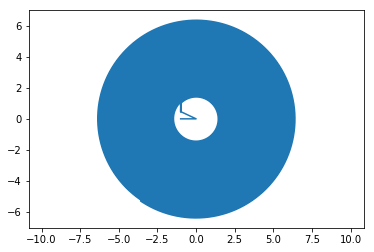

In [161]:
def f(x,y) :
    return x**2+y**2

def suivant(f, d, delta, grid):
    h=grad(f,d[0])
    o=d[0]+delta*h.orth().normalized()
                                                    #on utilise le gradient pour aller au prochain point
                                                                    #mais sans sortir de la grille
    if not ingrid(o,grid):
        o=d[0]-delta *h.orth().normalized() 
        
    prochain=theta(d[0],o)
    return((o,prochain))

import scipy
from scipy import optimize


def simple_contourdeux(f,c=0.0,delta=0.01,grid=[0.,1.,0.,1.],cote=lambda x:f(grid[0],x)):
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt(grid[0],t)
    g0 = grad(f,p=p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)
    p1 = pt()
    
    if ingrid(p11,grid):
        p1 = p11
    elif ingrid(p12,grid):
        p1 = p12
    else:
        return [],[]
    t1=theta(p0,p1)    #pi --> point    ti --> angle
    
    while len(pts)<100000:
        t1 = scipy.optimize.newton(g, t1, fprime=dg, args=(f, delta))
        p1 = p_a(p1, t1, delta)
        if not ingrid(pc,grid):
            return list_x_y(pts)
        else:
            pts.append(p1)
        p1, t1 = suivant(f, [p1,t1], delta, grid) #on change de point
    return list_x_y(pts)
grid1=[-1.,1.,-1.,1.]
i = 5
plt.axis('equal')
si = simple_contourdeux(f, c=1.2,grid=grid1, cote=lambda x:f(grid1[0],x))
plt.plot(si[0],si[1])

AttributeError: 'function' object has no attribute 'sin'

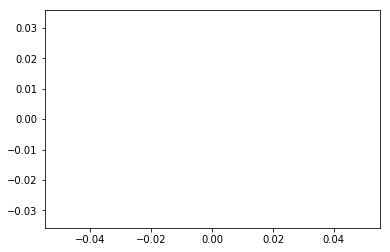

In [162]:
def f(x,y) :
    return x**2+y**2

def newton(ad, d, delta, f):
    derivee=dg(f,d[1],delta)
    if delta < 2**(-26): 
        #il faut quand même finir un jour
        return (d[0], d[1])                                                #si g'(d)=0, c'est qu'on est au bon endroit
    
    elif derivee < 2**(-26):
        return newton(ad, d, delta/2, f)                 
    
    elif abs(prochain-ad[1]) < 2**(-26):
        o=d[0]-delta *h.orth().normalized()
        if not ingrid(o,grid):
            raise ValueError("on boucle")
    elif abs(prochain-d[1])>abs(d[1]-ad[1]):                        #on ne doit pas trop s'éloigner 
        print("delta",delta)
        return newton(ad, d, delta/2, f)
    else:
        return (p_a(d[0],prochain-g(f,d[1],delta)/derivee,delta),prochain-g(f,d[1],delta)/derivee)

def suivant(f, d, delta, grid):
    h=grad(f,d[0])
    o=d[0]+delta*h.orth().normalized()
                                                    #on utilise le gradient pour aller au prochain point
                                                                    #mais sans sortir de la grille
    if not ingrid(o,grid):
        o=d[0]-delta *h.orth().normalized() 
        
    prochain=theta(d[0],o)
    return((o,prochain))

def simple_contourdeux(f,c=0.0,delta=0.01,grid=[0.,1.,0.,1.],cote=lambda x:f(grid[0],x)):
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt(grid[0],find_seed(cote,c))
    g0 = grad(f,p=p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)
    p1 = pt()
    
    if ingrid(p11,grid):
        p1 = p11
    elif ingrid(p12,grid):
        p1 = p12
    else:
        return [],[]
    t1=theta(p0,p1)    #pi --> point    ti --> angle
    p2, t2 = newton([p0,0.], [p1, t1], delta, f)
    
    pts = [p0,p1,p2]
    pa = p0 #avant-avant dernier point calculé
    pb = p1 #avant-dernier
    pc = p2 #dernier point calculé
    tb=t1
    tc=theta(p1,p2)
    while dist(pc,pa) > delta and dist(pc,pa) > delta and len(pts)<100000:
        while dist(pc,pb)>tolerance:
            pa = pb    
            ta = tb
            pb = pc
            tb = tc
            try:
                pc, tc = newton([pb,tb], [pc,tc], delta, f)  #on cherche le nouveau point à partir du dernier
            except ValueError as e:
                print(e)
        if not ingrid(pc,grid):
            return list_x_y(pts)
        else:
            pts.append(pc)
        pa, ta = suivant(f, [pc,tc], delta, grid) #on change de point
        pb, tb = newton([pc,tc], [pa,ta], delta, f)
        pc, tc = newton([pa,ta], [pb,tb], delta, f)
    return list_x_y(pts)
grid1=[-1.,1.,-1.,1.]
i = 5
plt.axis('equal')
si = simple_contourdeux(f, c=1.2,grid=grid1, cote=lambda x:f(grid1[0],x))
plt.plot(si[0],si[1])

In [ ]:
i = 5
plt.axis('equal')
def f(x,y) :
    return x**2+y**2
si = simple_contour(lambda x: f(0.0,x), c=0.02,grid=[-0.04,0.04,-0.04,0.03])
plt.plot(si[0],si[1])